In [1]:
%load_ext autoreload
%autoreload 2

# Modelo CNN con generador, embedings de smiles y data-augmentation

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
from datagen import smiles_dict, smiles_to_seq

2023-02-21 14:28:00.389737: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### smiles_dict

smiles_dict nos da un tokenizador para simplificar el problema. Puede ver como se construyó en la notebook **deep_chem**.
Si al momento de correr el modelo con este diccionario encuentra problemas de key_error, puede agregar los faltantes al diccionario

Mirar dentro de **datagen.py** como se usa este diccionario con la función **smiles_to_seq** para tokenizar. El código es muy sencillo

In [3]:
print(len(smiles_dict), smiles_dict, sep=" / ")

42 / {'#': 1, '(': 2, ')': 3, '+': 4, '-': 5, '/': 6, '1': 7, '2': 8, '3': 9, '4': 10, '5': 11, '6': 12, '7': 13, '8': 14, '=': 15, 'C': 16, 'F': 17, 'H': 18, 'I': 19, 'N': 20, 'O': 21, 'P': 22, 'S': 23, '[': 24, '\\': 25, ']': 26, '_': 27, 'c': 28, 'Cl': 29, 'Br': 30, 'n': 31, 'o': 32, 's': 33, '@': 34, '.': 35, 'a': 36, 'B': 37, 'e': 38, 'i': 39, '9': 40, '10': 41, '11': 42}


# Carga de los datos

In [4]:
df = pd.read_csv(
    'data/acetylcholinesterase_02_bioactivity_data_preprocessed.csv'
)

In [5]:
max_len_idx = df['canonical_smiles'].apply(len).argmax()
min_len_idx = df['canonical_smiles'].apply(len).argmin()
max_sequence_len = len(df['canonical_smiles'].iloc[max_len_idx]) + 20

In [6]:
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,standard_value_norm,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,750.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,100.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,50000.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,300.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,800.0,6.096910


In [7]:
X = df['canonical_smiles'].values
y = df['pIC50'].values

# Data augmentation:

https://arxiv.org/pdf/1703.07076.pdf

https://github.com/EBjerrum/molvecgen

https://github.com/Ebjerrum/SMILES-enumeration

En la publicación de arriba se describe una técnica de aumentación de datos para los smiles. Leerla si es de su interes (Opcional)

En el módulo **dataug.py**, tomando como referencia los repositorios arriba citados se implementó la aumentación de datos

In [8]:
from dataaug import SmilesEnumerator

sme = SmilesEnumerator()

for i in range(10):
    print(sme.randomize_smiles('CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1'))
    

n1(-c2cc(OCc3ccccc3)ccc2)c(=O)oc(OCC)n1
c1(COc2cc(-n3c(=O)oc(OCC)n3)ccc2)ccccc1
CCOc1nn(-c2cc(OCc3ccccc3)ccc2)c(=O)o1
n1c(OCC)oc(=O)n1-c1cc(OCc2ccccc2)ccc1
c1(-n2c(=O)oc(OCC)n2)cc(OCc2ccccc2)ccc1
CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1
CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1
n1(-c2cccc(OCc3ccccc3)c2)nc(OCC)oc1=O
n1c(OCC)oc(=O)n1-c1cc(OCc2ccccc2)ccc1
c1(-n2nc(OCC)oc2=O)cccc(OCc2ccccc2)c1


# DataGenerator

Construir un generador al que se le pase al instanciarlo:
- X: smiles (formula química)
- y: pIC50
- batch_size
- max_sequence_len (int): La máxima longitud de las secuencias (para hacer el padding)
- data_augmentation (boolean): si quiero hacer o no data-augmentation. 
- shuffle (boolean)

Guardarlo en el módulo **datagen.py** con el nombre de la clase **DataGenerator**

Notar que el módulo **datagen.py** ya tiene una estructura para completar

### Importamos el módulo y lo probamos

In [9]:
from datagen import DataGenerator

In [10]:
dgen = DataGenerator(X, y, max_sequence_len, batch_size=16)

In [11]:
len(dgen) * dgen.batch_size

5824

In [12]:
for i, (X_b, y_b) in enumerate(dgen):
    print(f'{i}\r', end='')

# Split

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=88
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train, 
    test_size=0.2, 
    random_state=88
)

len(X_train), len(X_val), len(X_test)

In [17]:
X_train

array(['c1ccc2[nH]c(NC34CC5CC(CC(C5)C3)C4)nc2c1',
       'CCOC(=O)c1c(C)nc(N2CCN(S(=O)(=O)c3ccc(NC(C)=O)cc3)CC2)nc1-c1ccccc1',
       'O=C(CCCCCCCNc1c2c(nc3cc(Cl)cc(Cl)c13)CCCC2)NCCc1c[nH]c2ccccc12',
       ..., 'CCCCCCCCOC[n+]1ccn(C)c1/C=N/O.[Cl-]',
       'Cc1c(C)c2ccc(OCCCCN(C)Cc3ccccc3)cc2oc1=O',
       'COc1ccc(/C=C/C(=O)NCCC2CCN(Cc3ccccc3)CC2)cc1OC'], dtype=object)

In [18]:
dgen_train = DataGenerator(X_train, y_train, seq_length=max_sequence_len, batch_size=128, data_augmentation=True)
dgen_val = DataGenerator(X_val, y_val, seq_length=max_sequence_len, batch_size=128, data_augmentation=False)
dgen_test = DataGenerator(X_test, y_test, seq_length=max_sequence_len, batch_size=128, data_augmentation=False)

In [19]:
for i, (X_b, y_b) in enumerate(dgen_test):
    print(f'{i}\r', end='')

In [20]:
X_b.shape

(13, 227)

# Network Model

In [21]:
from tensorflow.keras import backend as K

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, Activation, Embedding, Flatten, Dropout, 
    Concatenate, Input,
    Conv1D, MaxPool1D, GlobalAveragePooling1D
)


In [22]:
# Métrica
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def calculate_r2(y_true, y_pred, _round=8):
    return round(1 - ((y_true - y_pred.reshape(-1)) ** 2).sum() / ((y_true - y_true.mean()) ** 2).sum(), _round)

In [23]:
mcp = ModelCheckpoint(
    'models/best_model_{epoch}', 
    save_best_only=True, 
    save_format="h5"
)

In [24]:
# EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,                  # number of epochs with no improvement (0 means the training 
                                  # is terminated as soon as the performance measure gets worse 
                                  # from one epoch to the next)
    restore_best_weights=True
)

In [25]:
# Tensorboard
tensorboard = TensorBoard(
    log_dir="logs/fit/model-default",
    histogram_freq=1,
    write_graph=False,
    write_images=False
)

In [26]:
# Implementar modelo de TextCNN

def text_cnn_1d(sequence_length, vocab_size, embedding_size, filter_sizes, num_filters):
    """ """
    
    # ref: https://analyticsindiamag.com/guide-to-text-classification-using-textcnn/

    max_pool_div = 4  # new
    input_x = Input(shape=(sequence_length,), name='input_x')
    embedding = Embedding(vocab_size + 1, embedding_size, name='embedding')(input_x)
    pooled_outputs = []

    for filter_size in filter_sizes:
    
        conv = Conv1D(
            filters=num_filters, 
            kernel_size=filter_size, 
            activation="relu"
        )(embedding)

        max_p = MaxPool1D(
            pool_size=(sequence_length - filter_size + 1) // max_pool_div
        )(conv)

        pooled_outputs.append(max_p)    

    h_pool = Concatenate(axis=2)(pooled_outputs)
    dense = Flatten()(h_pool)
    dense = Dense(100, activation="relu")(dense)
    dense = Dense(50, activation="relu")(dense)
    dense = Dense(1)(dense) # Salida

    model = Model(input_x, dense)
    
    return model

In [27]:
# Hiperparámtros de referencia
FILTER_SIZES = (3, 4, 5)
NUM_FILTERS = 128
vocab_size = len(smiles_dict)
embeddings_size = 128

In [28]:
model = text_cnn_1d(
    max_sequence_len,
    vocab_size,
    embeddings_size,
    FILTER_SIZES,
    NUM_FILTERS
)

2023-02-21 14:28:10.782923: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [29]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=[R2])

In [30]:
## Tensorboard
from tensorboard import notebook
notebook.list() 

# %tensorboard --logdir logs/fit/
# !tensorboard --logdir logs/fit/ -> Run in your cli (with poetry)

Known TensorBoard instances:
  - port 6006: logdir logs/fit/ (started 1 day, 0:51:31 ago; pid 2193)


In [31]:
model_name = "modelTEextCNN"
tensorboard.log_dir = f"logs/fit/model-{model_name}-{dt.now().strftime('%Y%m%d_%H%M')}"

EPOCHS = 500  # La idea es que se detenga por el earlyStopping

history = model.fit(
    dgen_train, 
    epochs=EPOCHS, 
    validation_data=dgen_val,
    callbacks=[
        # mcp,
        early_stopping,
        tensorboard
    ]
)

Epoch 1/500
30/30 [==============================] - 9s 266ms/step - loss: 34.5813 - R2: -12.6284 - val_loss: 30.9043 - val_R2: -10.1393
Epoch 2/500
30/30 [==============================] - 9s 283ms/step - loss: 25.6211 - R2: -9.1589 - val_loss: 17.4200 - val_R2: -5.6030
Epoch 3/500
30/30 [==============================] - 8s 278ms/step - loss: 8.7150 - R2: -2.3630 - val_loss: 2.8840 - val_R2: -0.0116
Epoch 4/500
30/30 [==============================] - 8s 274ms/step - loss: 2.6715 - R2: -0.0216 - val_loss: 2.7890 - val_R2: 0.0146
Epoch 5/500
30/30 [==============================] - 7s 242ms/step - loss: 2.5460 - R2: 0.0232 - val_loss: 2.7725 - val_R2: 0.0294
Epoch 6/500
30/30 [==============================] - 9s 302ms/step - loss: 2.5233 - R2: 0.0411 - val_loss: 2.7523 - val_R2: 0.0356
Epoch 7/500
30/30 [==============================] - 9s 313ms/step - loss: 2.5055 - R2: 0.0458 - val_loss: 2.7328 - val_R2: 0.0439
Epoch 8/500
30/30 [==============================] - 8s 276ms/step - l

In [32]:
# Score

X_test_eval = []
y_t_eval = []

for X_t, y_t in dgen_test:
    X_test_eval = X_test_eval + [list(t) for t in X_t]
    y_t_eval = y_t_eval + list(y_t)
X_test_eval = np.array(X_test_eval)
y_test = np.array(y_t_eval)

X_test_eval.shape, y_test.shape
y_pred = model.predict(X_test_eval)

print(f"R2: {calculate_r2(y_test, y_pred, 3)}; ref value: 0.498")

37/37 [==============================] - 1s 17ms/step
R2: 0.471; ref value: 0.498


# Evaluación

<function matplotlib.pyplot.show(close=None, block=None)>

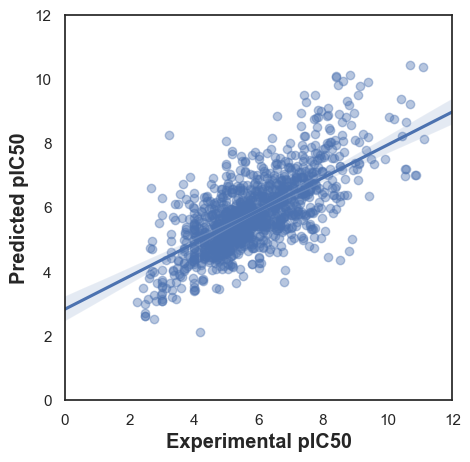

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show